Summary of Fraud Detection Code Lab
- Data is highly imbalanced
- Features of interval_after_signup and time related raw and aggregates are highly predictive of fraud
- Made actionable operation recommendations/proposal for business

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     |████████████████████████████████| 21.8 MB 5.8 MB/s 
     |████████████████████████████████| 10.9 MB 5.8 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 102 kB 46.7 MB/s 
     |████████████████████████████████| 690 kB 17.1 MB/s 
     |████████████████████████████████| 4.7 MB 13.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 812 kB 43.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.9 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=262599 sha256=a3b0200d7b1db0fbd70582a7adc523339c768bbda71749060d791aefd1a8a7da
  Stored in directory: /tmp/pip-ephem-wheel-cache-ndxosdln/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=4b128ee17842c42a849135e2b9154ad028cd2488105312d73f76c21a6869c66e
  Stored in directory: /ro

In [ ]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 199 kB 8.3 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Review/fraudData"

creditcard.csv	imbalancedFraudDF.csv  IpAddress_to_Country.csv


In [ ]:
ipToCountry = pd.read_csv('drive/My Drive/Review/fraudData/IpAddress_to_Country.csv')
fraud_data = pd.read_csv('drive/My Drive/Review/fraudData/imbalancedFraudDF.csv')

In [ ]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0


In [ ]:
fraud_data['class'].value_counts()

0    136961
1      1415
Name: class, dtype: int64

In [ ]:
#Inline summary report without saving report as object
from pandas_profiling import ProfileReport
ProfileReport(fraud_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fraud_data.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [ ]:
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']
    tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
fraud_data['country'] = countries
runtime = time.time() - start 

print("Lookup took", runtime, "seconds.")

Lookup took 152.34643244743347 seconds.


In [ ]:
my_try = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= 16777473) &
                    (ipToCountry['upper_bound_ip_address'] >= 16777473)]
my_try

,lower_bound_ip_address,upper_bound_ip_address,country
1,16777472.0,16777727,China


In [ ]:
my_try['country'].values[0]

'China'

##Feature Engineering (What types of features can we use?)

Q: How to check if column user_id is unique(no dup) for time related aggregates?

In [ ]:
print(fraud_data.user_id.nunique())
print(len(fraud_data))

138376
138376


In [ ]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


In [ ]:
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(
        fraud_data['signup_time'])).dt.total_seconds()

fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear

In [ ]:
fraud_data['signup_seconds_of_day'] = pd.DatetimeIndex(fraud_data['signup_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['signup_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['signup_time']).hour

fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear
fraud_data['purchase_seconds_of_day'] = pd.DatetimeIndex(fraud_data['purchase_time']).second + 60 * pd.DatetimeIndex(
    fraud_data['purchase_time']).minute + 3600 * pd.DatetimeIndex(fraud_data['purchase_time']).hour

fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis = 1)

In [ ]:
fraud_data.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,82549,108,10031
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,74390,159,5934
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,76405,124,50090
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,25792,252,67253
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,141,21783,190,29114


Q: What now? train/test split? transformation, e.g. normalization, convert categorical features e.g. device_id to numericals? or SMOTE sampling?

In [ ]:
y = fraud_data['class']
X = fraud_data.drop(['class'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (110700, 13)
y_train.shape: (110700,)


In [ ]:
X_train['country'].value_counts(ascending = True)

Benin                 1
Yemen                 1
Fiji                  1
Monaco                1
Madagascar            1
                  ...  
United Kingdom     3253
Japan              5251
China              8876
NA                16275
United States     42348
Name: country, Length: 177, dtype: int64

In [ ]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
29343,12,OULPAZAFRFPXP,Ads,Chrome,M,42,3.690922e+09,Korea Republic of,3499664.0,183,67384,224,24648
12190,10,AIIWMFEYQQIEB,Ads,Opera,M,29,1.686759e+09,United States,6766039.0,5,78146,84,18585
19388,34,VUVETBUPCIWJE,Direct,Chrome,M,53,4.138429e+09,NA,5870515.0,197,81354,265,76669
89104,48,QCFULAJOYKFUU,Ads,Chrome,M,29,9.617337e+07,France,2145618.0,160,30920,185,16538
82082,44,IHRWLMIJMEEEU,Ads,FireFox,M,24,1.936025e+09,China,7079059.0,111,71897,193,66156


In [ ]:
X_train = pd.get_dummies(X_train, columns=['source', 'browser'])
X_train['sex'] = (X_train.sex == 'M').astype(int)

In [ ]:
X_train_device_id_mapping = X_train.device_id.value_counts(dropna = False)#With dropna set to False we can also see NaN index values
X_train['n_dev_shared'] = X_train.device_id.map(X_train_device_id_mapping)

In [ ]:
X_train_ip_address_mapping = X_train.ip_address.value_counts(dropna = False)
X_train['n_ip_shared'] = X_train.ip_address.map(X_train_ip_address_mapping)

In [ ]:
X_train_country_mapping = X_train.country.value_counts(dropna = False)
X_train['n_country_shared'] = X_train.country.map(X_train_country_mapping)

In [ ]:
X_train = X_train.drop(['device_id','ip_address','country'], axis = 1)

In [ ]:
X_test = pd.get_dummies(X_test, columns = ['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)

In [ ]:
X_test['n_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna = False))

X_test['n_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna = False))

X_test['n_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna = False))

X_test = X_test.drop(['device_id','ip_address','country'], axis=1)

In [ ]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
29343,12,1,42,3499664.0,183,67384,224,24648,1,0,0,1,0,0,0,0,1,1,3075
12190,10,1,29,6766039.0,5,78146,84,18585,1,0,0,0,0,0,1,0,1,1,42348
19388,34,1,53,5870515.0,197,81354,265,76669,0,1,0,1,0,0,0,0,1,1,16275
89104,48,1,29,2145618.0,160,30920,185,16538,1,0,0,1,0,0,0,0,1,1,2322
82082,44,1,24,7079059.0,111,71897,193,66156,1,0,0,0,1,0,0,0,1,1,8876


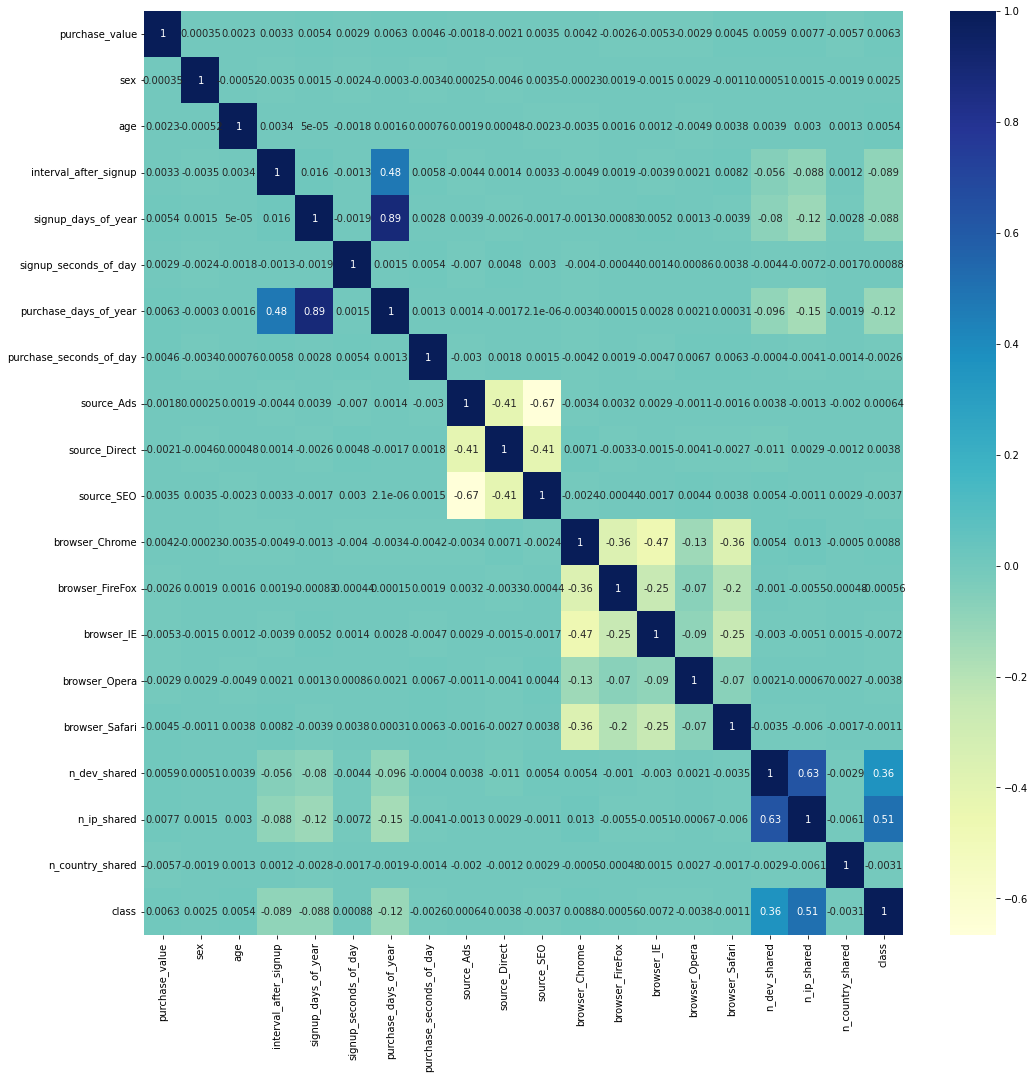

In [ ]:
import seaborn as sns

plt.figure(figsize = (17,17))
sns.heatmap(pd.concat([X_train,y_train],axis=1).corr(), cmap="YlGnBu", annot=True)
plt.show()

Q: What is the difference between normalization and standardization?

In [ ]:
scaler = MinMaxScaler().fit(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']]) 

X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

In [ ]:
X_train.n_dev_shared.value_counts(dropna = False)

0.0    105427
0.2      4774
0.4       324
0.6       124
0.8        45
1.0         6
Name: n_dev_shared, dtype: int64

In [ ]:
X_test.n_dev_shared.value_counts(dropna = False)

0.0    27330
0.2      334
0.4       12
Name: n_dev_shared, dtype: int64

Simple LogisticRegression model

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns = ['pred_0', 'pred_1'], index = ['true_0', 'true_1'])
cmDF

,pred_0,pred_1
true_0,27389,0
true_1,287,0


Simple RF model

In [ ]:
classifier_RF = RandomForestClassifier(random_state=0)

classifier_RF.fit(X_train, y_train)

predicted = classifier_RF.predict(X_test)

probs = classifier_RF.predict_proba(X_test)

In [ ]:
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted)))
print()
print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print()
print('recall =', float(cm[1,1])/(cm[1,0]+cm[1,1]))
print('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))

accuracy_score is: : 0.9948692007515537
roc_auc_score is: : 0.7801672204169557
f1_score is: : 0.6712962962962962

confusion_matrix is: 
        pred_0  pred_1
true_0   27389       0
true_1     142     145

recall = 0.5052264808362369
precision = 1.0


SMOTE sampling

In [ ]:
smote = SMOTE(random_state = 12)
x_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts = True)

print(np.asarray((unique, counts)).T)

[[     0 109572]
 [     1 109572]]


In [ ]:
y_train_sm.value_counts()

0    109572
1    109572
Name: class, dtype: int64

In [ ]:
y_train.value_counts()

0    109572
1      1128
Name: class, dtype: int64

In [ ]:
classifier_RF_sm = RandomForestClassifier(random_state=0)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

predicted_sm = classifier_RF_sm.predict(X_test)

probs_sm = classifier_RF_sm.predict_proba(X_test)

print("%s: %r" % ("accuracy_score_sm is: ", accuracy_score(y_test, predicted_sm)))
print("%s: %r" % ("roc_auc_score_sm is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print("%s: %r" % ("f1_score_sm is: ", f1_score(y_test, predicted_sm)))
print()
print("confusion_matrix_sm is: ")
cm_sm = confusion_matrix(y_test, predicted_sm)
cmDF = pd.DataFrame(cm_sm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print()
print('recall or sens_sm =',float(cm_sm[1,1])/(cm_sm[1,0]+cm_sm[1,1]))
print('precision_sm =', float(cm_sm[1,1])/(cm_sm[1,1] + cm_sm[0,1]))

accuracy_score_sm is: : 0.9948330683624801
roc_auc_score_sm is: : 0.7676158935089662
f1_score_sm is: : 0.6697459584295612

confusion_matrix_sm is: 
        pred_0  pred_1
true_0   27388       1
true_1     142     145

recall or sens_sm = 0.5052264808362369
precision_sm = 0.9931506849315068


# Parameter tuning by GridSearchCV

Eval metrics for GridSearchCV over all fits upon combination of parameters and cv

In [ ]:
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label = 1)  
}

In [ ]:
def grid_search_wrapper(model, parameters, refit_score = 'f1_score'):

    grid_search = GridSearchCV(model, parameters, scoring = scorers, refit = refit_score,
                           cv = 3, return_train_score = True)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))

    print('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search

Optimizing on f1_score on LR

In [ ]:
LRGrid = {"C" : np.logspace(-2,2,5), "penalty":["l1", "l2"]}
logRegModel = LogisticRegression(random_state = 0, solver = 'liblinear')

grid_search_LR_f1 = grid_search_wrapper(logRegModel, LRGrid, refit_score = 'f1_score')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for f1_score
{'C': 0.1, 'penalty': 'l1'}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27386       3
true_1     278       9
	roc_auc_score is: : 0.7596836543778924
	f1_score is: : 0.06020066889632108
recall =  0.0313588850174216
precision =  0.75


Optimizing on f1_score on RF

In [ ]:
parameters = {        
'max_depth': [None, 5, 15],
'n_estimators' :  [10,150],
'class_weight' : [{0: 1, 1: w} for w in [0.2, 1, 100]]
}

In [ ]:
clf = RandomForestClassifier(random_state=0)

In [ ]:
parameters['class_weight']

[{0: 1, 1: 0.2}, {0: 1, 1: 1}, {0: 1, 1: 100}]

In [ ]:
grid_search_rf_f1 = grid_search_wrapper(clf, parameters, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.2}, 'max_depth': None, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
	roc_auc_score is: : 0.7781993788548851
	f1_score is: : 0.6712962962962962
recall =  0.5052264808362369
precision =  1.0


In [ ]:
best_rf_model_f1 = grid_search_rf_f1.best_estimator_
best_rf_model_f1

RandomForestClassifier(class_weight={0: 1, 1: 0.2}, n_estimators=150,
                       random_state=0)

In [ ]:
results_f1 = pd.DataFrame(grid_search_rf_f1.cv_results_)
results_sortf1 = results_f1.sort_values(by='mean_test_f1_score', ascending=False)
results_f1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_precision_score,split1_test_precision_score,...,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,mean_train_f1_score,std_train_f1_score
0,1.472236,0.064025,0.100294,0.002361,"{0: 1, 1: 0.2}",None,10,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",0.995050,0.994845,...,0.677193,0.693241,0.688645,0.008150,10,0.921864,0.928011,0.917986,0.922620,0.004128
1,22.087021,0.121115,0.876527,0.002405,"{0: 1, 1: 0.2}",None,150,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.000000,1.000000,...,0.678383,0.694444,0.689845,0.008157,1,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.563896,0.028373,0.069445,0.001682,"{0: 1, 1: 0.2}",5,10,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.000000,0.984694,...,0.674825,0.694444,0.687905,0.009249,12,0.685315,0.695577,0.687609,0.689500,0.004398
3,8.159504,0.114003,0.390755,0.003001,"{0: 1, 1: 0.2}",5,150,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",1.000000,1.000000,...,0.678383,0.694444,0.689845,0.008157,1,0.686463,0.695577,0.687609,0.689883,0.004053
4,1.284043,0.033940,0.092276,0.000758,"{0: 1, 1: 0.2}",15,10,"{'class_weight': {0: 1, 1: 0.2}, 'max_depth': ...",0.990148,1.000000,...,0.678383,0.693241,0.688642,0.007267,11,0.743525,0.760099,0.751867,0.751831,0.006766


In [ ]:
pd.DataFrame(best_rf_model_f1.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

,importance
interval_after_signup,0.408875
purchase_days_of_year,0.132442
purchase_seconds_of_day,0.079075
signup_seconds_of_day,0.077661
signup_days_of_year,0.057319
n_ip_shared,0.052617
purchase_value,0.044106
age,0.038233
n_dev_shared,0.035686
n_country_shared,0.027432


Optimizing recall_score on RF

In [ ]:
grid_search_rf_recall = grid_search_wrapper(clf, parameters, refit_score='recall_score')

Best params for recall_score
{'class_weight': {0: 1, 1: 100}, 'max_depth': 5, 'n_estimators': 150}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27146     243
true_1     132     155
	roc_auc_score is: : 0.7904661234456265
	f1_score is: : 0.4525547445255475
recall =  0.5400696864111498
precision =  0.38944723618090454


In [ ]:
best_RF_model_recall = grid_search_rf_recall.best_estimator_
best_RF_model_recall

RandomForestClassifier(class_weight={0: 1, 1: 100}, max_depth=5,
                       n_estimators=150, random_state=0)

In [ ]:
predictedBest_recall = best_RF_model_recall.predict(X_test)
probsBest_recall = best_RF_model_recall.predict_proba(X_test)

results_recall = pd.DataFrame(grid_search_rf_recall.cv_results_)
results_sortrecall = results_recall.sort_values(by='mean_test_recall_score', ascending = False)
results_sortrecall[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head(20)

,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
15,0.159,0.636,0.254,0.164,0.656,0.262,5,"{0: 1, 1: 100}",150
14,0.160,0.633,0.255,0.162,0.652,0.260,5,"{0: 1, 1: 100}",10
16,0.675,0.533,0.593,0.759,0.813,0.782,15,"{0: 1, 1: 100}",10
0,0.995,0.527,0.689,1.000,0.856,0.923,None,"{0: 1, 1: 0.2}",10
1,1.000,0.527,0.690,1.000,1.000,1.000,None,"{0: 1, 1: 0.2}",150
13,1.000,0.527,0.690,1.000,1.000,1.000,None,"{0: 1, 1: 100}",150
11,1.000,0.527,0.690,1.000,0.584,0.737,15,"{0: 1, 1: 1}",150
10,0.992,0.527,0.688,1.000,0.613,0.760,15,"{0: 1, 1: 1}",10
9,1.000,0.527,0.690,1.000,0.527,0.690,5,"{0: 1, 1: 1}",150
7,1.000,0.527,0.690,1.000,1.000,1.000,None,"{0: 1, 1: 1}",150


In [ ]:
parameters = {
    'num_leaves' : [30,35,50,100,200],
    'learning_rate':[0.001,0.01,0.1,0.5,1,2,10],
    'n_estimators':[30,40,50,100,300,500]
    
}

from lightgbm import LGBMClassifier

LGBMC = LGBMClassifier(random_state=10)
grid_search_light_recall = grid_search_wrapper(LGBMC, parameters, refit_score='recall_score')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

Best params for recall_score
{'learning_rate': 0.1, 'n_estimators': 40, 'num_leaves': 35}

Confusion matrix of Random Forest optimized for recall_score on the test data:
        pred_0  pred_1
true_0   27389       0
true_1     142     145
	roc_auc_score is: : 0.7744528660059997
	f1_score is: : 0.6712962962962962
recall =  0.5052264808362369
precision =  1.0


In [ ]:
res_light = pd.DataFrame(grid_search_light_recall.cv_results_)
res_light = res_light.sort_values(by='mean_test_recall_score', ascending = False)
res_light

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_num_leaves,params,split0_test_precision_score,split1_test_precision_score,...,split1_test_f1_score,split2_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score,split0_train_f1_score,split1_train_f1_score,split2_train_f1_score,mean_train_f1_score,std_train_f1_score
71,0.504521,0.007291,0.109853,0.000573,0.1,50,35,"{'learning_rate': 0.1, 'n_estimators': 50, 'nu...",0.975845,0.994845,...,0.677193,0.692042,0.687401,0.007228,42,0.716724,0.718910,0.709013,0.714882,0.004245
66,0.440021,0.012061,0.098895,0.000197,0.1,40,35,"{'learning_rate': 0.1, 'n_estimators': 40, 'nu...",0.975845,1.000000,...,0.678383,0.692042,0.687797,0.006668,39,0.706793,0.711225,0.701209,0.706409,0.004098
63,0.527942,0.009762,0.113031,0.000769,0.1,30,100,"{'learning_rate': 0.1, 'n_estimators': 30, 'nu...",0.975728,1.000000,...,0.678383,0.696707,0.688604,0.007629,28,0.780211,0.773246,0.770237,0.774565,0.004177
59,11.133094,0.055549,2.918533,0.050935,0.01,500,200,"{'learning_rate': 0.01, 'n_estimators': 500, '...",0.995050,1.000000,...,0.678383,0.694444,0.689443,0.007832,18,1.000000,1.000000,1.000000,1.000000,0.000000
70,0.505329,0.002548,0.108879,0.002983,0.1,50,30,"{'learning_rate': 0.1, 'n_estimators': 50, 'nu...",0.980488,0.994845,...,0.677193,0.693241,0.687448,0.007272,41,0.706793,0.705680,0.706793,0.706422,0.000525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,0.332052,0.003964,0.079904,0.004098,0.01,30,35,"{'learning_rate': 0.01, 'n_estimators': 30, 'n...",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,163,0.000000,0.000000,0.000000,0.000000,0.000000
30,0.323594,0.008965,0.076528,0.001766,0.01,30,30,"{'learning_rate': 0.01, 'n_estimators': 30, 'n...",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,163,0.000000,0.000000,0.000000,0.000000,0.000000
28,6.387656,0.311676,1.293346,0.002488,0.001,500,100,"{'learning_rate': 0.001, 'n_estimators': 500, ...",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,163,0.000000,0.000000,0.000000,0.000000,0.000000
27,3.726992,0.056311,0.500185,0.024623,0.001,500,50,"{'learning_rate': 0.001, 'n_estimators': 500, ...",0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,163,0.000000,0.000000,0.000000,0.000000,0.000000


# Project tasks

In [ ]:
trainDF = pd.concat([X_train, y_train], axis=1)
pd.crosstab(trainDF["n_dev_shared"],trainDF["class"])

class,0,1
n_dev_shared,,
0.0,104966,461
0.2,4403,371
0.4,152,172
0.6,37,87
0.8,13,32
1.0,1,5


In [ ]:
fraud_data.groupby("class")[['interval_after_signup']].mean()

,interval_after_signup
class,
0,5.191179e+06
1,2.570226e+06


In [ ]:
fraud_data.groupby("class")[['interval_after_signup']].median()

,interval_after_signup
class,
0,5194911.0
1,1.0


In [ ]:
fraud_data[fraud_data['class'] == 1].head(100)

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day
136961,24,VLHGCDPFCICDA,SEO,Chrome,F,33,3.432126e+09,1,United States,3327952.0,218,80113,257,38465
136962,14,YLUQSRNYYIPXU,Ads,Chrome,M,40,3.905319e+09,1,NA,1.0,12,4207,12,4208
136963,63,ABUBCQDATQMQH,Ads,FireFox,F,46,5.505670e+08,1,United States,7640070.0,49,40723,137,77593
136964,34,QHEODGCAVJKIQ,SEO,Chrome,M,37,9.408096e+08,1,United States,1.0,12,77710,12,77711
136965,76,DAKVYHKIEYRBH,SEO,Chrome,F,48,6.361041e+08,1,Hungary,1.0,10,48421,10,48422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137056,21,AIGPGDVRDKOKT,SEO,FireFox,F,45,3.058136e+09,1,India,1.0,2,69762,2,69763
137057,52,PQGKGQACIARBV,Ads,Chrome,F,36,7.203338e+08,1,China,1.0,9,77018,9,77019
137058,54,XHZBVWFWHSGTQ,SEO,FireFox,M,50,2.249217e+09,1,United States,1.0,1,32483,1,32484
137059,10,WETYPHOQVLWMK,Ads,FireFox,M,36,2.293333e+09,1,United States,1.0,7,63914,7,63915


In [ ]:
#for task 4, how to use the prediction:
t = (10 * probsBest_recall[:, 1]).astype(int)
unique, counts = np.unique(t, return_counts = True)

print(np.asarray((unique, counts)).T)

#recommended:
#green: 1 - 3 pass
#grey: 4-7 need manual investigation
#red: 8,9 decline

[[    1     1]
 [    2 24555]
 [    3  2623]
 [    4    99]
 [    5   177]
 [    6    76]
 [    7     1]
 [    8    20]
 [    9   124]]
